In [1]:
import random
random.seed(14672458)
seed = 14672458

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from scipy.stats.mstats import winsorize

In [4]:
df = pd.read_csv('musicData.csv')
df = df.dropna()
le = LabelEncoder()

# convert music_genre into numeric labels
df['music_genre_encoded'] = le.fit_transform(df['music_genre'])
# convert key into numeric label
key_dummies = pd.get_dummies(df['key'], prefix='key')
df = pd.concat([df.drop(columns=['key']), key_dummies], axis=1)

# Convert 'mode' to dummy variables (one-hot encoding)
mode_dummies = pd.get_dummies(df['mode'], prefix='mode')
df = pd.concat([df.drop(columns=['mode']), mode_dummies], axis=1)

In [5]:
df = df.drop(columns = ['instance_id','artist_name','track_name','music_genre','key_A','mode_Major','obtained_date'],axis = 1)

In [6]:
test_df_list = []
train_df_list = []

for genre, group in df.groupby('music_genre_encoded'):
    test_part = group.sample(n=500, random_state=seed)
    train_part = group.drop(test_part.index)
    test_df_list.append(test_part)
    train_df_list.append(train_part)

test_df = pd.concat(test_df_list).reset_index(drop=True)
train_df = pd.concat(train_df_list).reset_index(drop=True)

# Handle missing values ONLY based on train set

train_df['tempo'] = train_df['tempo'].replace('?', np.nan)
train_df['tempo'] = train_df['tempo'].astype(float)
test_df['tempo'] = test_df['tempo'].replace('?', np.nan)
test_df['tempo'] = test_df['tempo'].astype(float)

# For train set: fill missing based on group medians
train_df['duration_ms'] = train_df.groupby('music_genre_encoded')['duration_ms']\
    .transform(lambda x: x.replace(-1, np.median(x[x != -1])))

train_df['tempo'] = train_df.groupby('music_genre_encoded')['tempo']\
    .transform(lambda x: x.fillna(x.median()))

# For test set: fill missing using train set medians
# First, compute medians from train
duration_medians = train_df.groupby('music_genre_encoded')['duration_ms'].median()
tempo_medians = train_df.groupby('music_genre_encoded')['tempo'].median()

# Then fill test set
def fill_duration(row):
    if row['duration_ms'] == -1:
        return duration_medians[row['music_genre_encoded']]
    else:
        return row['duration_ms']

def fill_tempo(row):
    if pd.isna(row['tempo']):
        return tempo_medians[row['music_genre_encoded']]
    else:
        return row['tempo']

test_df['duration_ms'] = test_df.apply(fill_duration, axis=1)
test_df['tempo'] = test_df.apply(fill_tempo, axis=1)

# Finally, separate features and labels
X_train = train_df.drop('music_genre_encoded', axis=1)
y_train = train_df['music_genre_encoded']

X_test = test_df.drop('music_genre_encoded', axis=1)
y_test = test_df['music_genre_encoded']

In [7]:
dummy_cols = [col for col in X_train.columns if set(X_train[col].dropna().unique()).issubset({0, 1})]
continuous_cols = X_train.columns.difference(dummy_cols)

# Standardize continuous variables
scaler = StandardScaler()
X_train_scaled_cont = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled_cont = scaler.transform(X_test[continuous_cols])

# Rebuild full DataFrames
X_train_scaled = pd.concat([
    pd.DataFrame(X_train_scaled_cont, columns=continuous_cols, index=X_train.index),
    X_train[dummy_cols]
], axis=1)

X_test_scaled = pd.concat([
    pd.DataFrame(X_test_scaled_cont, columns=continuous_cols, index=X_test.index),
    X_test[dummy_cols]
], axis=1)

# Restore original column order
X_train_scaled = X_train_scaled[X_train.columns]
X_test_scaled = X_test_scaled[X_test.columns]

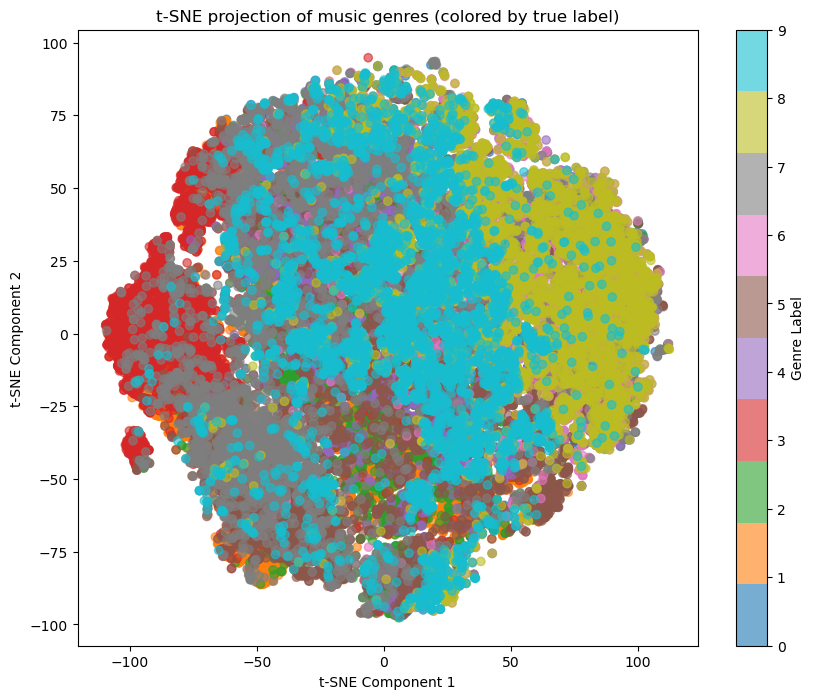

In [11]:
tsne = TSNE(n_components=2, perplexity=30, random_state=seed)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='tab10', alpha=0.6)
plt.title("t-SNE projection of music genres (colored by true label)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Genre Label")
plt.show()

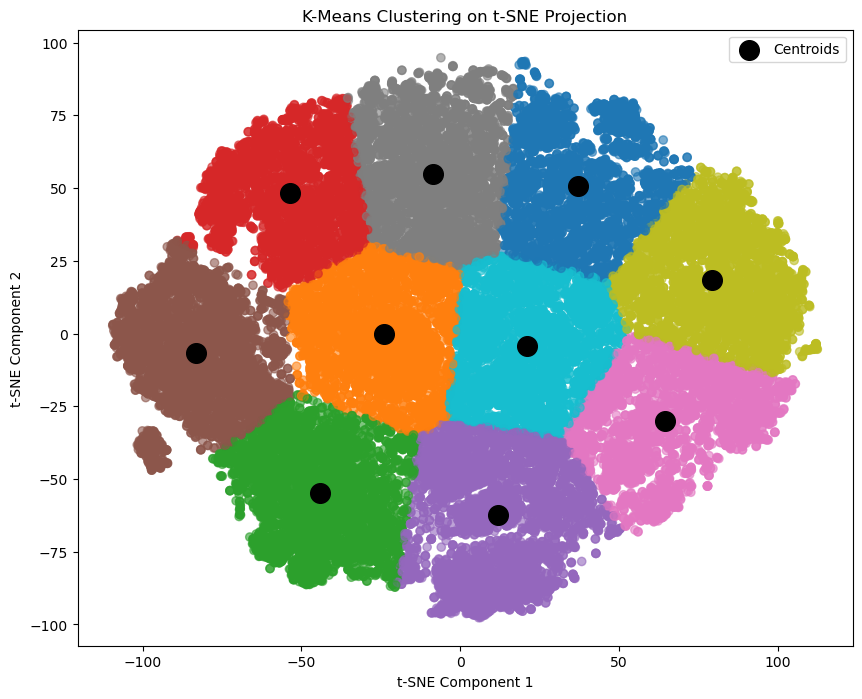

In [12]:
n_clusters = len(np.unique(y_train))

# Apply KMeans on the t-SNE projected data
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=seed)
clusters_tsne = kmeans_tsne.fit_predict(X_tsne)

# Plot the K-Means clusters on t-SNE projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_tsne, cmap='tab10', alpha=0.6)
plt.scatter(kmeans_tsne.cluster_centers_[:, 0], kmeans_tsne.cluster_centers_[:, 1],
            s=200, c='black', label='Centroids')
plt.title("K-Means Clustering on t-SNE Projection")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

Random Forest after PCA
              precision    recall  f1-score   support

           0       0.38      0.34      0.36       500
           1       0.76      0.67      0.71       500
           2       0.53      0.50      0.51       500
           3       0.81      0.84      0.83       500
           4       0.51      0.52      0.51       500
           5       0.63      0.60      0.61       500
           6       0.31      0.35      0.33       500
           7       0.49      0.47      0.48       500
           8       0.28      0.25      0.26       500
           9       0.46      0.59      0.52       500

    accuracy                           0.51      5000
   macro avg       0.52      0.51      0.51      5000
weighted avg       0.52      0.51      0.51      5000

Random Forest accuracy with PCA = 51.3%
Macro-averaged AUC with PCA: 0.894


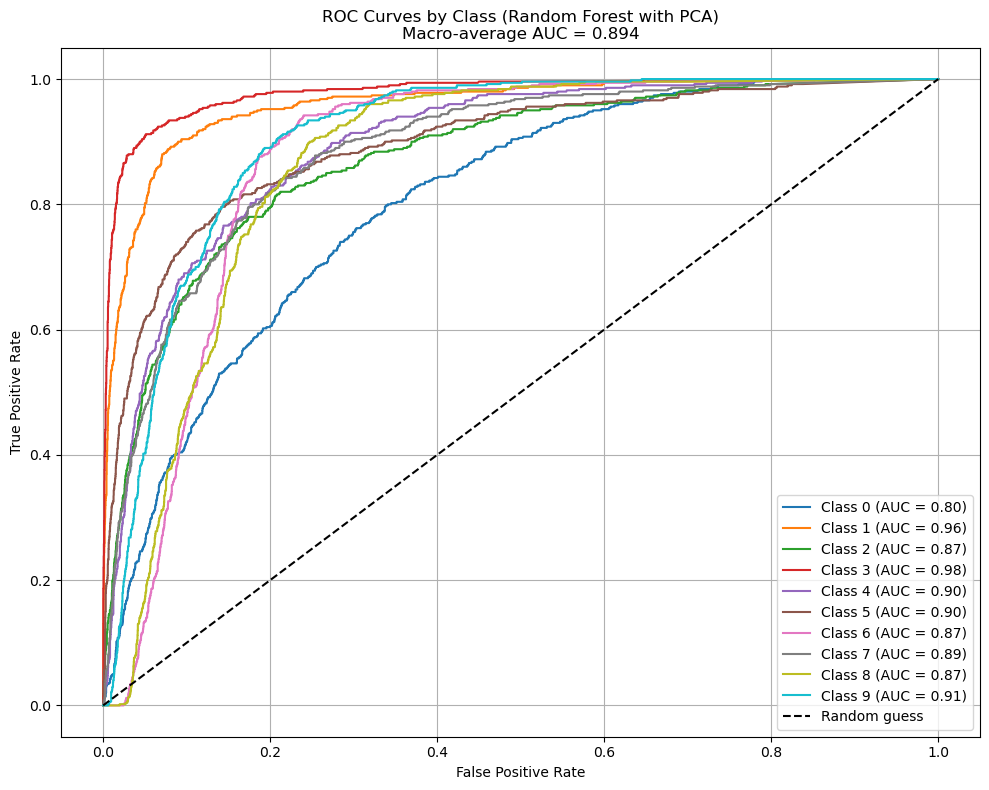

In [16]:
# Try random forest after PCA
pca = PCA(n_components=0.99, whiten=True, random_state=seed)
X_train_pca = pca.fit_transform(X_train_scaled)  
X_test_pca = pca.transform(X_test_scaled)

# Fit Random Forest on PCA-reduced features
clf_pca = RandomForestClassifier(n_estimators=100, max_samples=0.5, max_features=0.5,
                                 bootstrap=True, criterion='gini', random_state=seed)
clf_pca.fit(X_train_pca, y_train)
pred_all_pca = clf_pca.predict(X_test_pca)
print('Random Forest after PCA')
print(classification_report(y_test, pred_all_pca))
acc_pca = np.sum(pred_all_pca == y_test) / len(pred_all_pca)
print('Random Forest accuracy with PCA = {:0.1f}%'.format(100 * acc_pca))

# Prepare for multiclass ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# One-vs-rest classifier using PCA-reduced data
classifier_pca = OneVsRestClassifier(RandomForestClassifier(random_state=seed, n_estimators=100))
y_score_pca = classifier_pca.fit(X_train_pca, y_train).predict_proba(X_test_pca)

# Compute macro-averaged AUC
macro_auc_pca = roc_auc_score(y_test_bin, y_score_pca, average='macro', multi_class='ovr')
print(f"Macro-averaged AUC with PCA: {macro_auc_pca:.3f}")

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0 or np.any(np.isnan(y_score_pca[:, i])):
        print(f"Skipping class {i} (no positives or NaNs)")
        continue
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_pca[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves by Class (Random Forest with PCA)\nMacro-average AUC = {macro_auc_pca:.3f}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.43      0.38      0.40       500
           1       0.77      0.71      0.74       500
           2       0.55      0.49      0.52       500
           3       0.84      0.84      0.84       500
           4       0.50      0.50      0.50       500
           5       0.62      0.56      0.59       500
           6       0.31      0.35      0.33       500
           7       0.52      0.51      0.51       500
           8       0.29      0.27      0.28       500
           9       0.48      0.63      0.54       500

    accuracy                           0.53      5000
   macro avg       0.53      0.53      0.53      5000
weighted avg       0.53      0.53      0.53      5000

Random Forest accuracy with LDA = 52.6%
Macro-averaged AUC with LDA: 0.905


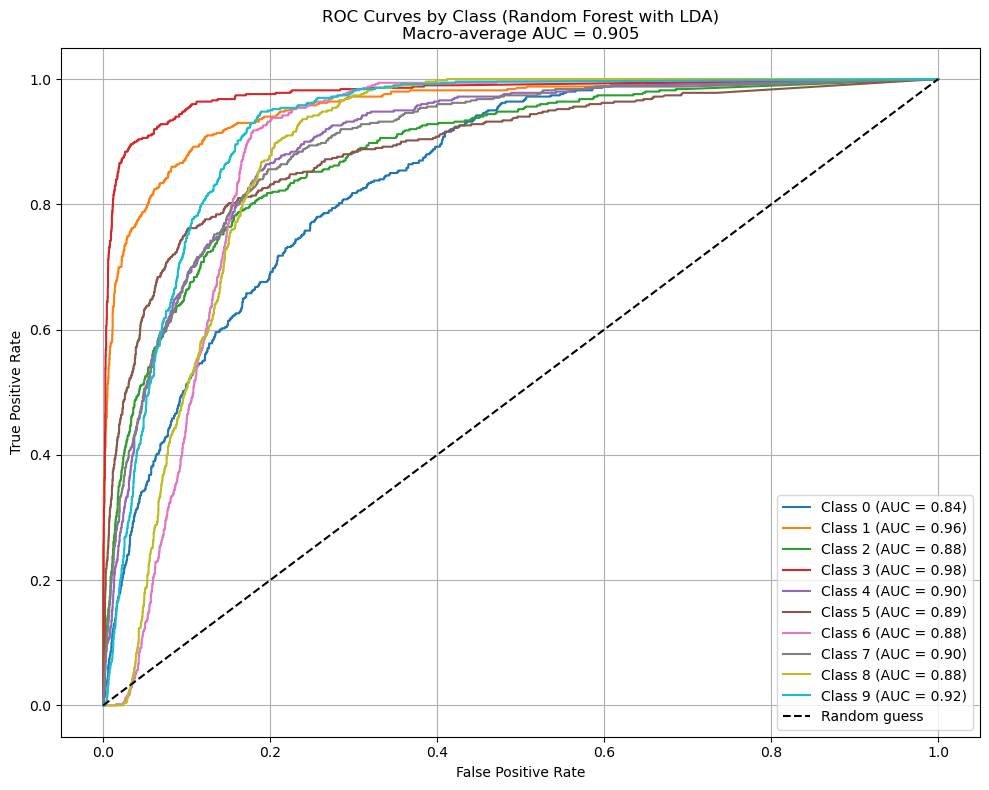

In [18]:
# Try random forest after LDA
lda = LDA(n_components=None)  # max dimension = (n_classes - 1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Fit Random Forest on LDA-reduced features
clf_lda = RandomForestClassifier(n_estimators=100, max_samples=0.5, max_features=0.5,
                                 bootstrap=True, criterion='gini', random_state=seed)
clf_lda.fit(X_train_lda, y_train)
pred_all_lda = clf_lda.predict(X_test_lda)
print(classification_report(y_test, pred_all_lda))
acc_lda = np.sum(pred_all_lda == y_test) / len(pred_all_lda)
print('Random Forest accuracy with LDA = {:0.1f}%'.format(100 * acc_lda))

# Prepare for multiclass ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# One-vs-rest classifier using LDA-reduced data
classifier_lda = OneVsRestClassifier(RandomForestClassifier(random_state=seed, n_estimators=100))
y_score_lda = classifier_lda.fit(X_train_lda, y_train).predict_proba(X_test_lda)

# Compute macro-averaged AUC
macro_auc_lda = roc_auc_score(y_test_bin, y_score_lda, average='macro', multi_class='ovr')
print(f"Macro-averaged AUC with LDA: {macro_auc_lda:.3f}")

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0 or np.any(np.isnan(y_score_lda[:, i])):
        print(f"Skipping class {i} (no positives or NaNs)")
        continue
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_lda[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves by Class (Random Forest with LDA)\nMacro-average AUC = {macro_auc_lda:.3f}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

AdaBoost after PCA
              precision    recall  f1-score   support

           0       0.36      0.22      0.27       500
           1       0.55      0.56      0.56       500
           2       0.52      0.29      0.37       500
           3       0.54      0.82      0.65       500
           4       0.42      0.45      0.43       500
           5       0.56      0.52      0.54       500
           6       0.39      0.52      0.44       500
           7       0.41      0.42      0.42       500
           8       0.32      0.29      0.31       500
           9       0.50      0.52      0.51       500

    accuracy                           0.46      5000
   macro avg       0.46      0.46      0.45      5000
weighted avg       0.46      0.46      0.45      5000

AdaBoost accuracy with PCA: 46.0%
Macro-averaged AUC with PCA: 0.802


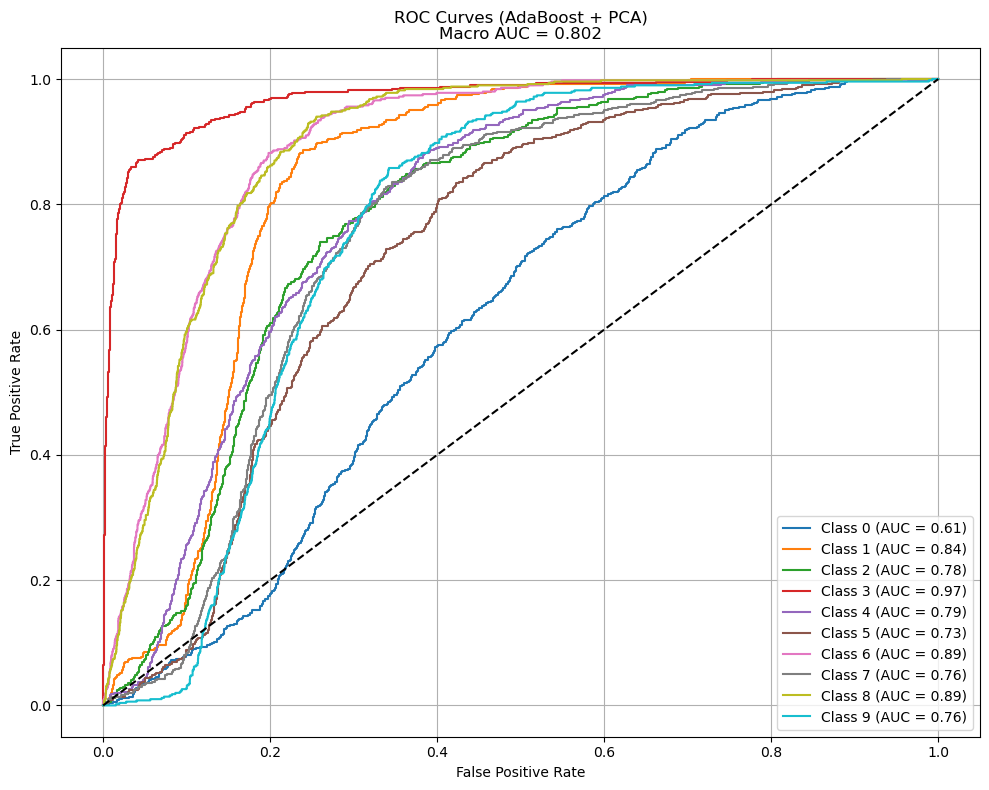

In [26]:
# Try AdaBoost after PCA
pca = PCA(n_components=0.99, whiten=True, random_state=seed)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

ada_pca = AdaBoostClassifier(n_estimators=100, random_state=seed)
ada_pca.fit(X_train_pca, y_train)
pred_pca = ada_pca.predict(X_test_pca)

print("AdaBoost after PCA")
print(classification_report(y_test, pred_pca))
acc_pca = np.mean(pred_pca == y_test)
print(f"AdaBoost accuracy with PCA: {acc_pca*100:.1f}%")

# ROC-AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_bin.shape[1]

classifier_pca = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=seed))
y_score_pca = classifier_pca.fit(X_train_pca, y_train).predict_proba(X_test_pca)

macro_auc_pca = roc_auc_score(y_test_bin, y_score_pca, average='macro', multi_class='ovr')
print(f"Macro-averaged AUC with PCA: {macro_auc_pca:.3f}")

# Plot ROC
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0 or np.any(np.isnan(y_score_pca[:, i])):
        continue
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_pca[:, i])
    class_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {class_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"ROC Curves (AdaBoost + PCA)\nMacro AUC = {macro_auc_pca:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

AdaBoost after LDA
              precision    recall  f1-score   support

           0       0.41      0.22      0.28       500
           1       0.41      0.82      0.54       500
           2       0.40      0.14      0.21       500
           3       0.63      0.57      0.60       500
           4       0.48      0.45      0.46       500
           5       0.53      0.35      0.42       500
           6       0.37      0.35      0.36       500
           7       0.41      0.36      0.38       500
           8       0.30      0.29      0.30       500
           9       0.41      0.74      0.53       500

    accuracy                           0.43      5000
   macro avg       0.43      0.43      0.41      5000
weighted avg       0.43      0.43      0.41      5000

AdaBoost accuracy with LDA: 42.9%
Macro-averaged AUC with LDA: 0.762


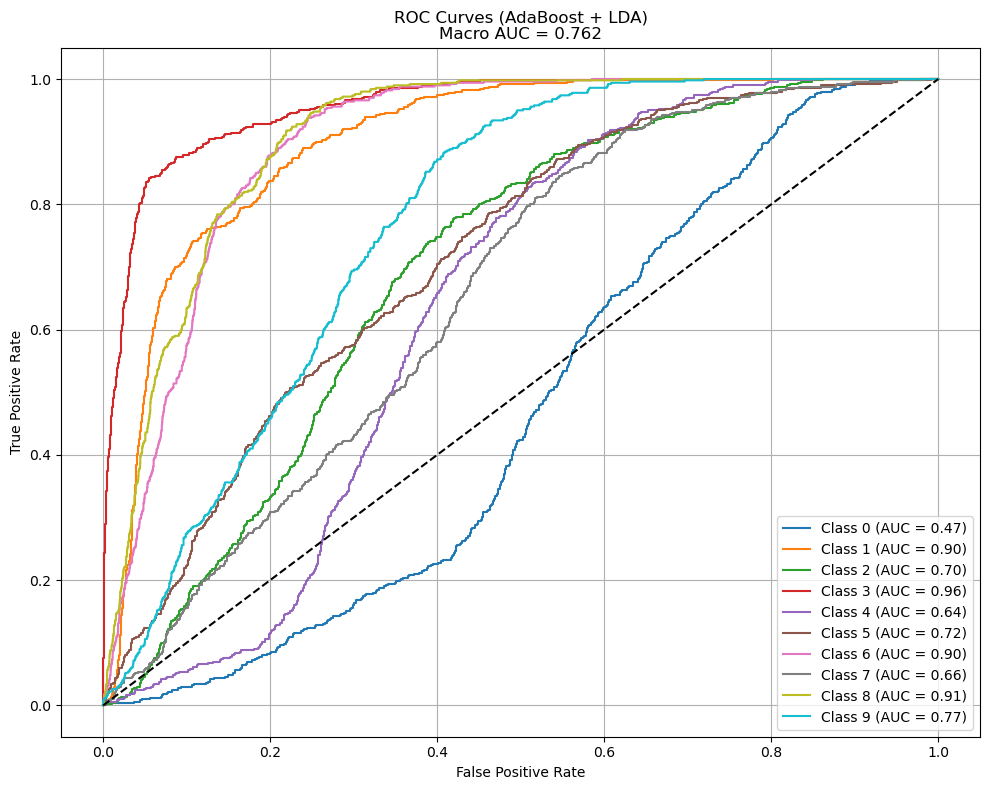

In [28]:
# Try AdaBoost after LDA
lda = LDA(n_components=None)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Train AdaBoost on LDA-reduced features
ada_lda = AdaBoostClassifier(n_estimators=100, random_state=seed)
ada_lda.fit(X_train_lda, y_train)
pred_lda = ada_lda.predict(X_test_lda)

print("AdaBoost after LDA")
print(classification_report(y_test, pred_lda))
acc_lda = np.mean(pred_lda == y_test)
print(f"AdaBoost accuracy with LDA: {acc_lda*100:.1f}%")

# ROC-AUC
y_score_lda = OneVsRestClassifier(
    AdaBoostClassifier(n_estimators=100, random_state=seed)
).fit(X_train_lda, y_train).predict_proba(X_test_lda)

macro_auc_lda = roc_auc_score(y_test_bin, y_score_lda, average='macro', multi_class='ovr')
print(f"Macro-averaged AUC with LDA: {macro_auc_lda:.3f}")

# Plot ROC
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0 or np.any(np.isnan(y_score_lda[:, i])):
        continue
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_lda[:, i])
    class_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {class_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"ROC Curves (AdaBoost + LDA)\nMacro AUC = {macro_auc_lda:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Full LDA-reduced model accuracy = 0.524
Full LDA-reduced model macro-AUC = 0.905

Dropping feature: popularity
Dropping feature: acousticness
Dropping feature: danceability
Dropping feature: duration_ms
Dropping feature: energy
Dropping feature: instrumentalness
Dropping feature: liveness
Dropping feature: loudness
Dropping feature: speechiness
Dropping feature: tempo
Dropping feature: valence
Dropping feature: key_A#
Dropping feature: key_B
Dropping feature: key_C
Dropping feature: key_C#
Dropping feature: key_D
Dropping feature: key_D#
Dropping feature: key_E
Dropping feature: key_F
Dropping feature: key_F#
Dropping feature: key_G
Dropping feature: key_G#
Dropping feature: mode_Minor

Impact of dropping each feature (with LDA):
     feature_dropped  accuracy  accuracy_drop  macro_auc  auc_drop
0         popularity    0.3814         0.1426   0.825419  0.079361
8        speechiness    0.5092         0.0148   0.893781  0.010999
2       danceability    0.5010         0.0230   0.894444  0

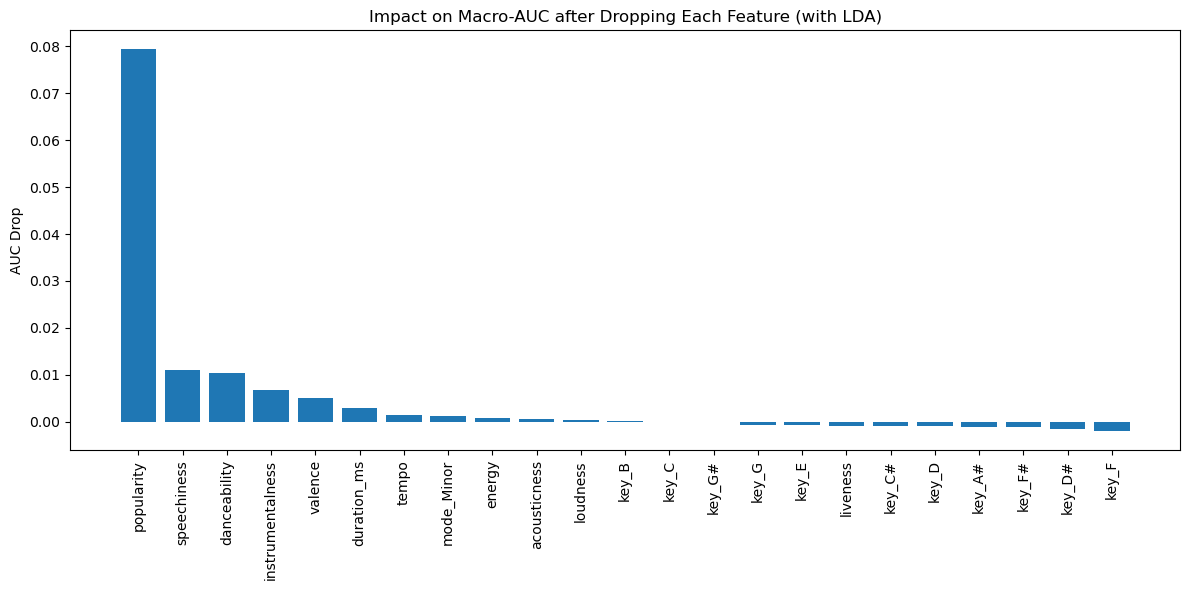

In [8]:
# First, get the full LDA-reduced baseline performance
lda_full = LDA(n_components=None)
X_train_lda_full = lda_full.fit_transform(X_train_scaled, y_train)
X_test_lda_full = lda_full.transform(X_test_scaled)

clf_full = RandomForestClassifier(n_estimators=100, max_samples=0.5, max_features=0.5,
                                  bootstrap=True, criterion='gini', random_state=seed)
clf_full.fit(X_train_lda_full, y_train)
pred_full = clf_full.predict(X_test_lda_full)
full_acc = np.mean(pred_full == y_test)

classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
classifier_full = OneVsRestClassifier(RandomForestClassifier(random_state=seed, n_estimators=100))
y_score_full = classifier_full.fit(X_train_lda_full, y_train).predict_proba(X_test_lda_full)
full_macro_auc = roc_auc_score(y_test_bin, y_score_full, average='macro', multi_class='ovr')

print(f"Full LDA-reduced model accuracy = {full_acc:.3f}")
print(f"Full LDA-reduced model macro-AUC = {full_macro_auc:.3f}\n")

# Initialize results list
results = []

# Loop through and drop each original feature
for feature in X_train.columns:
    print(f"Dropping feature: {feature}")
    
    X_train_drop = X_train.drop(columns=[feature])
    X_test_drop = X_test.drop(columns=[feature])
    
    # Apply LDA after dropping the feature
    lda = LDA(n_components=None)
    X_train_lda = lda.fit_transform(X_train_drop, y_train)
    X_test_lda = lda.transform(X_test_drop)
    
    # Train and evaluate
    clf = RandomForestClassifier(n_estimators=100, max_samples=0.5, max_features=0.5,
                                 bootstrap=True, criterion='gini', random_state=seed)
    clf.fit(X_train_lda, y_train)
    pred = clf.predict(X_test_lda)
    acc = np.mean(pred == y_test)
    
    classifier = OneVsRestClassifier(RandomForestClassifier(random_state=seed, n_estimators=100))
    y_score = classifier.fit(X_train_lda, y_train).predict_proba(X_test_lda)
    macro_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
    
    acc_drop = full_acc - acc
    auc_drop = full_macro_auc - macro_auc
    
    results.append({
        'feature_dropped': feature,
        'accuracy': acc,
        'accuracy_drop': acc_drop,
        'macro_auc': macro_auc,
        'auc_drop': auc_drop
    })

# Compile and sort results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='auc_drop', ascending=False)

print("\nImpact of dropping each feature (with LDA):")
print(results_df)

# Plot AUC drop
plt.figure(figsize=(12, 6))
plt.bar(results_df['feature_dropped'], results_df['auc_drop'])
plt.xticks(rotation=90)
plt.ylabel('AUC Drop')
plt.title('Impact on Macro-AUC after Dropping Each Feature (with LDA)')
plt.tight_layout()
plt.show()